In [0]:
import torch

In [2]:
torch.__version__

'1.3.1'

In [0]:
import numpy as np

### Loading and visualizing datasets



*   We need to fetch mnist datasets from torchvision and perform basic transformations
*   We need to create dataloaders for fetched training and test datasets 



### Remember that

#### torch.utils.data.DataLoader is an iterator which provides features like:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0 ## number of subprocesses to be used for data loading
batch_size = 20 ## number of samples per batch to load
valid_size = 0.2 ## percentage of training set to be used for validation

## type of transform you are applying to data: here "convert data into float tensor"
transform = transforms.ToTensor()

### choosing MNIST dataset from datasets
train_data = datasets.MNIST(root = 'data', train = True, download=True, transform=transform)
test_data = datasets.MNIST(root = 'data', train = False, download=True, transform=transform)

## obtain indices of training data that will be used as validation data
num_train = len(train_data)
print("length of the original training data: {}".format(num_train))
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print("length of training data after split: {}".format(len(train_idx)))
print("length of validation data after split: {}".format(len(valid_idx)))
## define sampler to obtain train and validation data batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### creating dataloaders
train_loader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size=batch_size , num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, sampler = valid_sampler, batch_size=batch_size , num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)


length of the original training data: 60000
length of training data after split: 48000
length of validation data after split: 12000


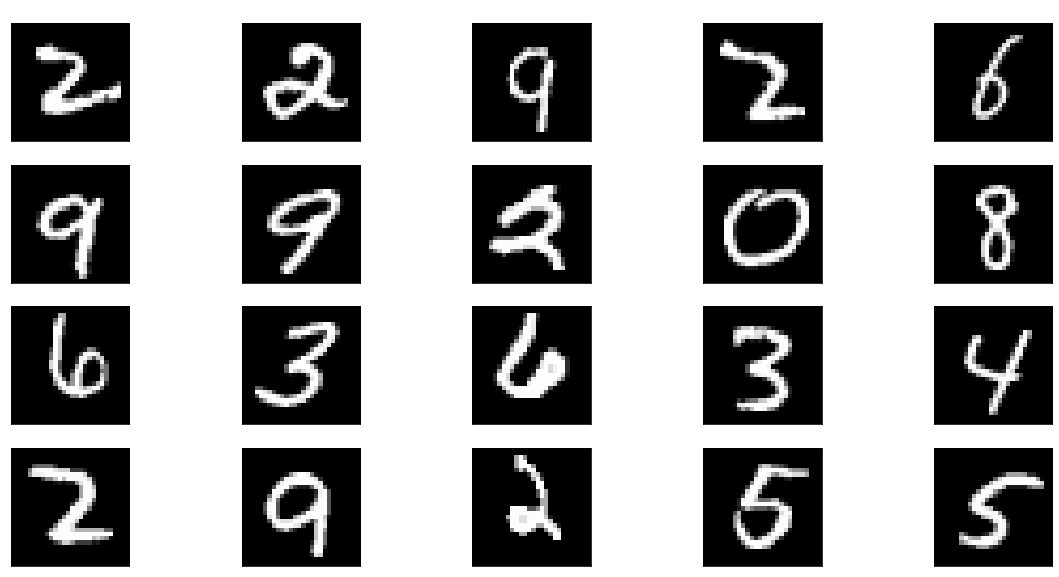

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

### take image from dataloader
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
fig = plt.figure(figsize = (20,10))


for idx in range(20):
    ax = fig.add_subplot(4,20/4,idx+1, xticks=[], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
    ax.set_title(str(labels[idx].item()), color = 'white')

In [8]:
images.shape

(20, 1, 28, 28)

In [9]:
images[1].shape

(1, 28, 28)

In [10]:
np.squeeze(images[1]).shape

(28, 28)

In [11]:
str(labels[2].item())

'9'

### Visualizing single image in a detail

In [12]:
img = np.squeeze(images[2])
print(img.shape)
print(img.max())

(28, 28)
1.0


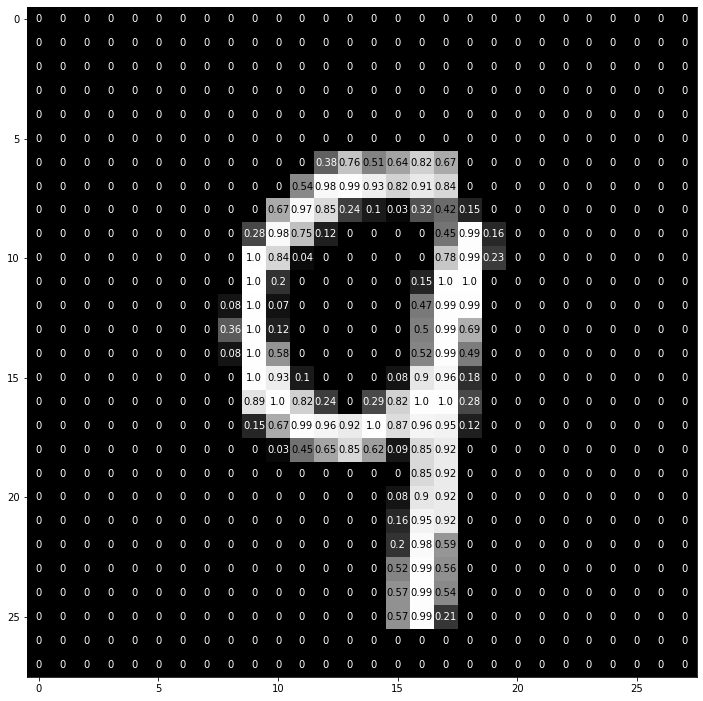

In [13]:
width, height = img.shape
thresh = img.max()/2.5

fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] != 0 else 0
        ax.annotate(str(val),xy = (y,x),
                    horizontalalignment= 'center',
                    verticalalignment = 'center',
                    color = 'white' if img[x][y] < thresh else 'black')

## Neural network architecture

* Input: A 784-dim Tensor of pixel values for each image
* Output: A Tensor of length 10 (our number of classes) that indicates the class scores for an input image.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
input_dim = 28*28 ## input to neural network
no_classes = 10 ## output from neural network

## Inheriting neural network class from nn.Module
class Net(nn.Module): 
    def __init__(self):
        super(Net,self).__init__()
        
        ## number of hidden nodes in each layer 512
        hidden_1 = 512
        hidden_2 = 512
        ## linear layer definitions
        self.fc1 = nn.Linear(input_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, no_classes)

        ## dropout to prevent overfitting of the data
        ## the outputs are scaled by a factor of \frac{1}{1-p} during training to compensate for no dropout in evaluation mode
        self.dropout = nn.Dropout(p = 0.2) ## p is the probability of the neuron to be zeroed

## PyTorch networks created with nn.Module must have a forward method defined. 
## It takes in a tensor x and passes it through the operations you defined in the init method.

    def forward(self,x):
        ## feedforward behavior of the network
        x = x.view(-1,input_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

## Training and validating the model.
#### Note: Definition of model, criterion and optimizer is done

In [17]:
n_epochs = 50 ## number of times to pass through complete training set 


# initialize tracker for minimum validation loss
min_valid_loss = np.Inf

for epoch in range(n_epochs):
    ## monitor training loss
    train_loss = 0.0 ## set training loss initial value to 0.0 at the start of each epoch
    valid_loss = 0.0 ## set validation loss initial value to 0.0 at the start of each epoch

    ####################################
    ######-----Train the model----######
    ####################################
    model.train() ## prepare the model for training

    for data, target in train_loader:
        ## data will be single batch from training data
        optimizer.zero_grad()  ## clear gradients of all optimized variables

        output = model(data) ## forward pass

        loss = criterion(output, target) ## compute the loss

        loss.backward() ## compute gradient of loss w.r.t model parameters

        optimizer.step() ## update the parameter values

        train_loss += loss.item()*data.size(0) ## mulitply the average loss computed over the batch given by loss.item() with the batch size 

        
    ##############################
    ##----validate the model----##
    ##############################
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    

    ## once the above for loop gets over, one epoch is completed
    train_loss = train_loss/len(train_loader.sampler) ## average training loss over an epoch
    valid_loss = valid_loss/len(valid_loader.sampler) ## average validation loss over an epoch

    print("Epoch: {}, \tTraining_loss: {:.6f} \tValidation_loss: {:.6f}".format(epoch+1, train_loss, valid_loss))

    if valid_loss < min_valid_loss :
        print("validation loss decreased {:.6f}---->{:.6f} @Epoch: {}".format(min_valid_loss, valid_loss, epoch+1))
        torch.save(model.state_dict(), "model.pt")
        min_valid_loss = valid_loss

Epoch: 1, 	Training_loss: 0.939378 	Validation_loss: 0.380807
validation loss decreased inf---->0.380807 @Epoch: 1
Epoch: 2, 	Training_loss: 0.356122 	Validation_loss: 0.293152
validation loss decreased 0.380807---->0.293152 @Epoch: 2
Epoch: 3, 	Training_loss: 0.280832 	Validation_loss: 0.239487
validation loss decreased 0.293152---->0.239487 @Epoch: 3
Epoch: 4, 	Training_loss: 0.232713 	Validation_loss: 0.200335
validation loss decreased 0.239487---->0.200335 @Epoch: 4
Epoch: 5, 	Training_loss: 0.199087 	Validation_loss: 0.186271
validation loss decreased 0.200335---->0.186271 @Epoch: 5
Epoch: 6, 	Training_loss: 0.172693 	Validation_loss: 0.155844
validation loss decreased 0.186271---->0.155844 @Epoch: 6
Epoch: 7, 	Training_loss: 0.153531 	Validation_loss: 0.137757
validation loss decreased 0.155844---->0.137757 @Epoch: 7
Epoch: 8, 	Training_loss: 0.136819 	Validation_loss: 0.125410
validation loss decreased 0.137757---->0.125410 @Epoch: 8
Epoch: 9, 	Training_loss: 0.125029 	Validatio

In [18]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Test the trained network/model

In [19]:
## monitor test loss
test_loss = 0.0

## evaluate model's performance for individual class
class_correct = [0 for x in range(10)]
class_total = [0 for x in range(10)]

model.eval() ## setting the model in evaluation mode
## This affects layers like dropout layers that turn "off" nodes during training with some probability, 
## but should allow every node to be "on" for evaluation.

for data, target in test_loader:
    ## get the batch of data from test loader

    output = model(data) ## make forward pass

    loss = criterion(output, target) ## computer loss for the batch

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    #print("shape of batch prediction: ", pred.shape)

    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    #print("shape of correct array", correct.shape)

    for i in range(len(target)):
        label = target.data[i]  ## label of ith data in the batch
        class_correct[label] += correct[i].item() ## make changes in ith index of class_correct list by adding 0 or 1
        class_total[label] += 1 ## always add 1 to the ith index of class_total list
    
# once pass through complete test data is done, compute average test loss

test_loss = test_loss/len(test_loader.sampler)
print("test loss: {:.6f}".format(test_loss))

## Let's check the accuracy for individual class

for i in range(no_classes):
    if class_total[i] > 0:
        print("Test accuracy of %5s: %2d%% (%2d/%2d)" % (
            str(i), 100*class_correct[i]/class_total[i],
            class_correct[i], class_total[i]
        ))
    else:
        print("Test accuracy of %5s: N/A no data samples" % str(i))

print("Overall Test accuracy: %2d%% (%2d/%2d)" %(
    100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
) )

test loss: 0.059370
Test accuracy of     0: 98% (970/980)
Test accuracy of     1: 99% (1129/1135)
Test accuracy of     2: 97% (1010/1032)
Test accuracy of     3: 97% (986/1010)
Test accuracy of     4: 98% (965/982)
Test accuracy of     5: 97% (871/892)
Test accuracy of     6: 98% (939/958)
Test accuracy of     7: 98% (1010/1028)
Test accuracy of     8: 98% (956/974)
Test accuracy of     9: 97% (983/1009)
Overall Test accuracy: 98% (9819/10000)


## View sample test results

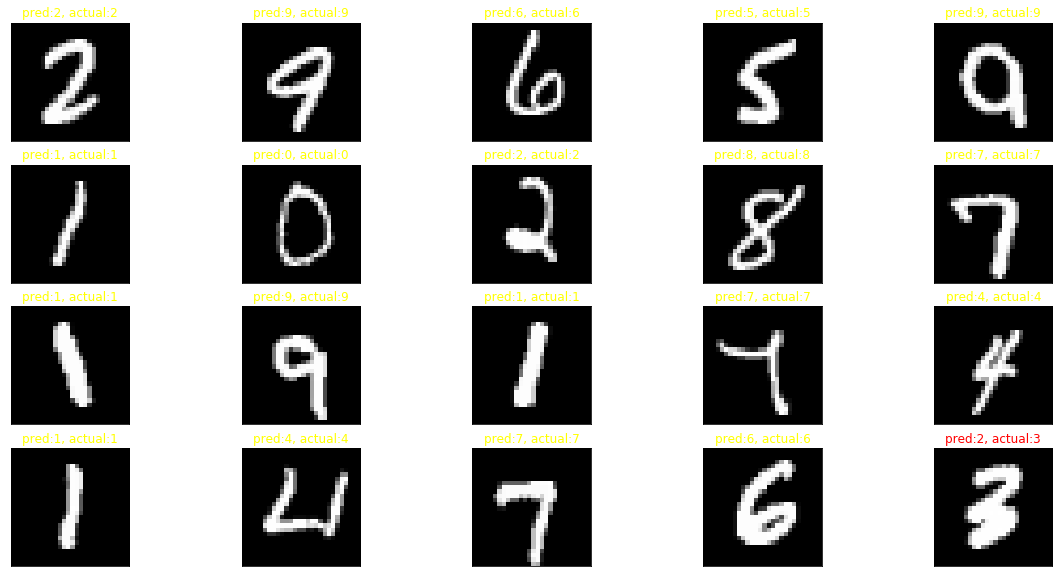

In [20]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images) ## predictions

_,preds = torch.max(output, 1) ## convert output probabilities to predicted class

images = images.numpy()

fig = plt.figure(figsize=(20,10))

for idx in range(20):
    ax = fig.add_subplot(4,20/4,idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("pred:{}, actual:{}".format(str(preds[idx].item()),str(labels[idx].item())), color = 'red' if preds[idx]!=labels[idx].item() else 'yellow' )